# Pipeline de modélisation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")

from sklearn import tree, ensemble, linear_model, svm, neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load # pour enregistrer et charger les modèles.

from IPython.display import display_html # pour pouvoir afficher deux df côte à côte.

n_coeurs = 4

# 1. Resampling, optimisation et entrainement des modèles

In [3]:
# Instanciation df
df = pd.read_csv('ready_all.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# Séparation data / target:
X = df.drop(columns = ['RainTomorrow', 'Date', 'NonMesNum']).copy()
y = df['RainTomorrow'].copy()



# Séparation du jeu d'entrainement et du jeu de test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# UnderSample grâce à ClusterCentroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)

# Oversample avec SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)


C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
##### Automatisation de GridSearch
# Dictionnaire des modèles et zone de recherche des paramètres.
    # Clé = modèle, valeurs = liste [modèle, dict_paramètres] 
    # avec dic_paramètres dictionnaire: clé = hyperparamètre, valeur = liste des valeurs explorées pour l'hyperparamètre correspondant.

dict_grid = {'logreg' : [ linear_model.LogisticRegression(class_weight = 'balanced', n_jobs = n_coeurs), {"C" : np.logspace(-3, 3, num = 7)} ],
             
            'dt' : [ tree.DecisionTreeClassifier(class_weight = 'balanced'),  {"criterion" : ['gini', 'entropy', 'log_loss'],
                                                                               "max_depth" : [5, 10, 50, 100]}], 
             
            'rdf' : [ ensemble.RandomForestClassifier(class_weight = 'balanced', n_jobs = n_coeurs), {"n_estimators" : [5, 10, 50, 100, 300], 
                                                                                   "criterion" :['gini', 'entropy', 'log_loss']}  ], 
             
            'knn' : [ neighbors.KNeighborsClassifier(n_jobs = n_coeurs) , {"n_neighbors" : [10, 25, 50, 100], 
                                                          "metric" : ['minkowski', 'manhattan', 'chebyshev'],
                                                          "weights": ['uniform', 'distance']}]
             
            #'svm' : [ svm.SVC(class_weight = 'balanced'), {"C" : np.logspace(-2, 2, num = 5),
                                                           #"kernel" :['rbf', 'poly', 'sigmoid'] , 
                                                           #"gamma" : np.logspace(-2, 2, num = 5)} ]
            }

# Recherche et sauvegarde des meilleurs paramètres pour chaque modele:
for model in dict_grid.keys():
    clf = dict_grid[model][0]
    params = dict_grid[model][1]
    
    grid = GridSearchCV(estimator = clf, param_grid = params, cv = 4, scoring = 'f1_macro')
    
    # Entrainement et recherche:
    # kNN n'ayant pas la possibilité de spécifier class_weight = 'balanced', il faut l'entrainer spécifiquement sur des classes rééquilibrées en amont.
    if model != 'knn':
        grid.fit(X_train, y_train) # en général,  on entraine sur X_train, y_train. 
                                   # Il n'y a pas de prob de déséquilibre de classe pour ces modèles grâce à class_weight = 'balanced'    
    else:
        grid.fit(X_cc, y_cc)  # On choisit d'entrainer knn sur le resampling ClusterCentroids CC.
                       
    best_params = grid.best_params_
    print(str(model)+" best params:", best_params)
    
    # Sauvegarde du grid search par modèle. ADRESSE A MODIFIER EN FONCTION DU DF
    dump(grid, 'alex_df_all/grid_saves/grid_'+str(model)+'.joblib')                

logreg best params: {'C': 1.0}
dt best params: {'criterion': 'gini', 'max_depth': 10}
rdf best params: {'criterion': 'log_loss', 'n_estimators': 300}
knn best params: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}


In [6]:
# Chargement des grid: ADRESSE A MODIFIER EN FONCTION DU DF
grid_logreg = load('alex_df_all/grid_saves/grid_logreg.joblib')
grid_dt = load('alex_df_all/grid_saves/grid_dt.joblib')
grid_rdf = load('alex_df_all/grid_saves/grid_rdf.joblib')
grid_knn = load('alex_df_all/grid_saves/grid_knn.joblib')
#grid_svm = load('alex_df_all/grid_saves/grid_svm.joblib')

In [7]:
# Définition d'un dictionnaire pour appeler dans la fonction report, avec les best params de GridSearchCV
models = {"logreg" : linear_model.LogisticRegression(C = grid_logreg.best_params_['C'], n_jobs = n_coeurs), 
          "dt"  : tree.DecisionTreeClassifier(criterion =  grid_dt.best_params_['criterion'], max_depth =  grid_dt.best_params_['max_depth']),
          "rdf" : ensemble.RandomForestClassifier(n_estimators =  grid_rdf.best_params_['n_estimators'], criterion =  grid_rdf.best_params_['criterion'], n_jobs = n_coeurs),
          "knn" : neighbors.KNeighborsClassifier(n_neighbors =  grid_knn.best_params_['n_neighbors'], metric = grid_knn.best_params_['metric'], n_jobs = n_coeurs)}
          # "svm" : svm.SVC(kernel = grid_svm.best_params_['kernel'], C =  grid_svm.best_params_['C'], gamma =  grid_svm.best_params_['gamma'])}

In [8]:
def report_df(model, sampling, evaluation):
    # Cette fonction entraine le modèle choisi sur les données X_train et y_train (qui sont ré-équilibrées en amont)
    # et fait des prédictions sur X_test et y_test (qui elles, ne doivent pas être rééquilibrées)
    # On affiche ensuite le rapport complet: matrice de confusion et classification report
    
    # Définition de X_train et y_train en fonction du choix du sampling: 
    if sampling == 'SMOTE':
        X_train = X_sm
        y_train = y_sm
    elif sampling == 'CC':
        X_train = X_cc
        y_train = y_cc
        
    # Instanciation et entrainement du modèle:
    clf = models[model]
    clf.fit(X_train, y_train)
    
    # Sauvegarde du modèle: # ADRESSE A MODIFIER
    dump(clf, 'alex_df_all/model_saves/save_' + str(model) + '_' + str(sampling) + '.joblib')
    
    # Prédiction et évaluation:
    if evaluation == 'train':
        y_train_pred = clf.predict(X_train)
        #conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_train, y_train_pred, output_dict=True, digits = 2)).T    # création au format df
        
    else:
        y_test_pred = clf.predict(X_test)
        #conf_mat = pd.crosstab(y_test,y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites'])       # Création au format df
        class_rep = pd.DataFrame.from_dict(classification_report(y_test, y_test_pred, output_dict=True, digits = 2)).T    # création au format df
    
    # Création du titre en fonction du modèle et du ré-échantillonage choisi:
    if sampling == 'SMOTE':
        title = 'Rapport pour'+ ' ' + str(model) + ' ' + ' avec SMOTE'
    elif sampling == 'CC':
        title = 'Rapport pour'+ ' ' + str(model) + ' ' + ' avec ClusterCentroids'
        
    
    # Enregistrement des résultats:
    acc    = class_rep['precision'][2]
    prec_0 = class_rep['precision'][0]
    rec_0  = class_rep['recall'][0]
    f1_0   = class_rep['f1-score'][0]
    prec_1 = class_rep['precision'][1]
    rec_1  = class_rep['recall'][1]
    f1_1   = class_rep['f1-score'][1]
    f1_macro_avg = class_rep['f1-score'][3]
    f1_weighted_avg = class_rep['f1-score'][4]
 
    # Résumé des résultats arrondis et pourcentisés dans un dictionnaire:
    dict = {'Modele' : model, 
            'Sampling' : sampling,
            'Evaluation' : evaluation,
            'accuracy' :   round(acc*100, 1),     
            'precision_0 ': round(prec_0*100, 1), 
            'recall_0 ':    round(rec_0*100, 1),  
            'f1_0':         round(f1_0*100, 1),   
            'precision_1': round(prec_1*100, 1), 
            'recall_1':    round(rec_1*100, 1),  
            'f1_1':         round(f1_1*100, 1), 
            'f1_macro_avg' : round(f1_macro_avg*100, 1),
            'f1_weighted_avg': round(f1_weighted_avg*100, 1)}
    # Sortie:
    return dict

In [9]:
# Création d'un df avec les résultats des différents modèles:

dict_report = {}
keyList = ['Modele', 'Sampling','Evaluation', 'accuracy', 'precision_0 ', 'recall_0 ', 'f1_0', 'precision_1', 'recall_1', 'f1_1', 'f1_macro_avg', 'f1_weighted_avg']
dict_report = {key: [] for key in keyList}

for model in models:
    for sample in ['SMOTE', 'CC']:
        for key in keyList:
            for eva in ['train', 'test']:
                dict_report[key].append(report_df(model, sample, eva)[key]) # utilise la fonction report_df précédente.
            
df_report = pd.DataFrame.from_dict(dict_report)
df_report.to_csv('alex_df_all/reports/alex_report_all.csv')
df_report

,Modele,Sampling,Evaluation,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,f1_macro_avg,f1_weighted_avg
0,logreg,SMOTE,train,80.4,80.0,81.2,80.6,80.9,79.7,80.3,80.4,80.4
1,logreg,SMOTE,test,80.7,93.1,81.4,86.9,53.7,78.1,63.7,75.3,81.8
2,logreg,CC,train,77.7,77.5,78.0,77.7,77.8,77.4,77.6,77.7,77.7
3,logreg,CC,test,80.0,92.7,80.9,86.4,52.7,77.0,62.6,74.5,81.2
4,dt,SMOTE,train,85.3,84.6,86.5,85.5,86.0,84.1,85.1,85.3,85.3
5,dt,SMOTE,test,81.4,90.9,84.7,87.7,55.7,69.0,61.5,74.6,82.0
6,dt,CC,train,85.9,87.4,83.8,85.6,84.5,88.0,86.2,85.9,85.9
7,dt,CC,test,68.9,92.9,64.9,76.6,39.4,82.0,53.1,64.7,71.3
8,rdf,SMOTE,train,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
9,rdf,SMOTE,test,86.3,90.8,91.9,91.4,69.2,66.8,67.7,79.6,86.3


# 2. Analyse des résultats et choix des meilleurs modèles

## 2.1 Résultats

C:\Users\AlexW\anaconda3\envs\projet_meteo\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


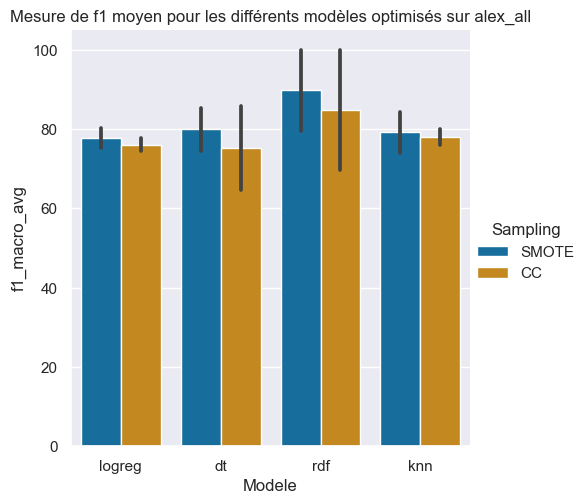

In [10]:
# Comparaison des différents modèles selon le f1_weighted_score:
df_report1 = pd.read_csv('alex_df_all/reports/alex_report_all.csv')

sns.catplot(data = df_report1, x = 'Modele', y = 'f1_macro_avg', hue = 'Sampling', kind = 'bar')
plt.title("Mesure de f1 moyen pour les différents modèles optimisés sur alex_all")

plt.show()

Pour le modèle, on a le choix entre:  
    * logreg : meilleur sur la précision de la classe 1  
    * rdf : un peu meilleur sur la classe 0

## 2.2 Features importances

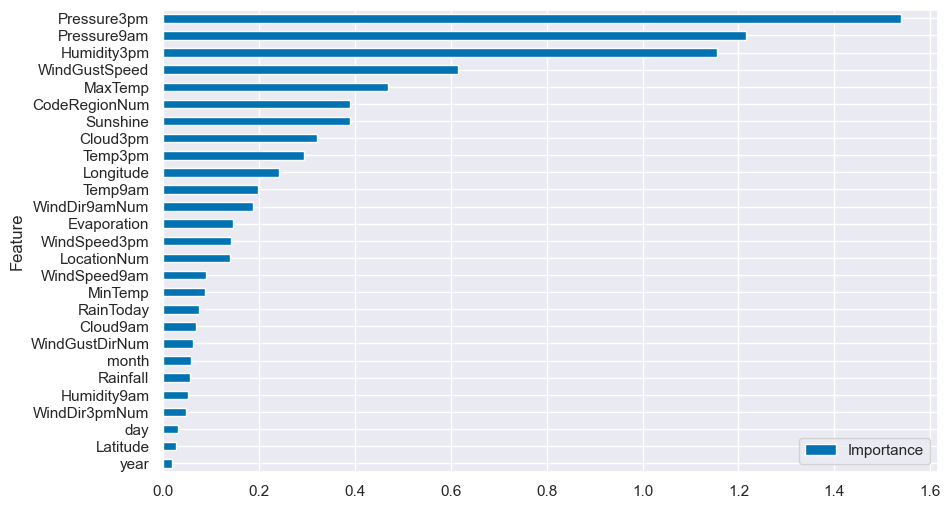

In [11]:
# Features importances pour logreg
# https://forecastegy.com/posts/feature-importance-in-logistic-regression/

logreg_best = load('alex_df_all/model_saves/save_logreg.joblib')

coefficients = logreg_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

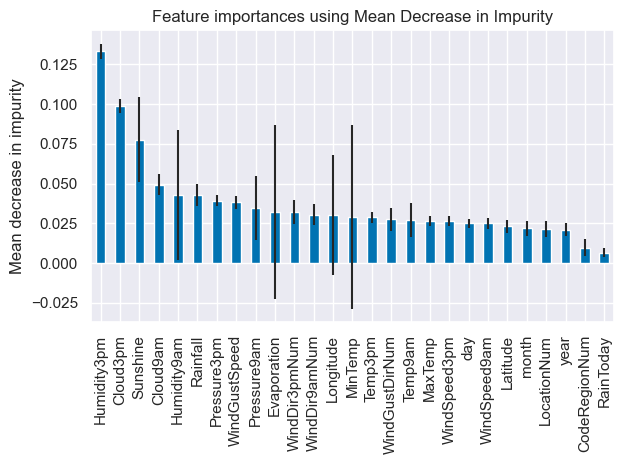

In [12]:
# Features importances pour rdf:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

rdf_best = load('alex_df_all/model_saves/save_rdf.joblib')

feature_names = X.columns
importances = rdf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rdf_best.estimators_], axis=0)

rdf_best_importances = pd.Series(importances, index=feature_names)
rdf_best_importances = rdf_best_importances.sort_values(ascending = False)

fig, ax = plt.subplots()
rdf_best_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 2.3 Recherche d'overfitting

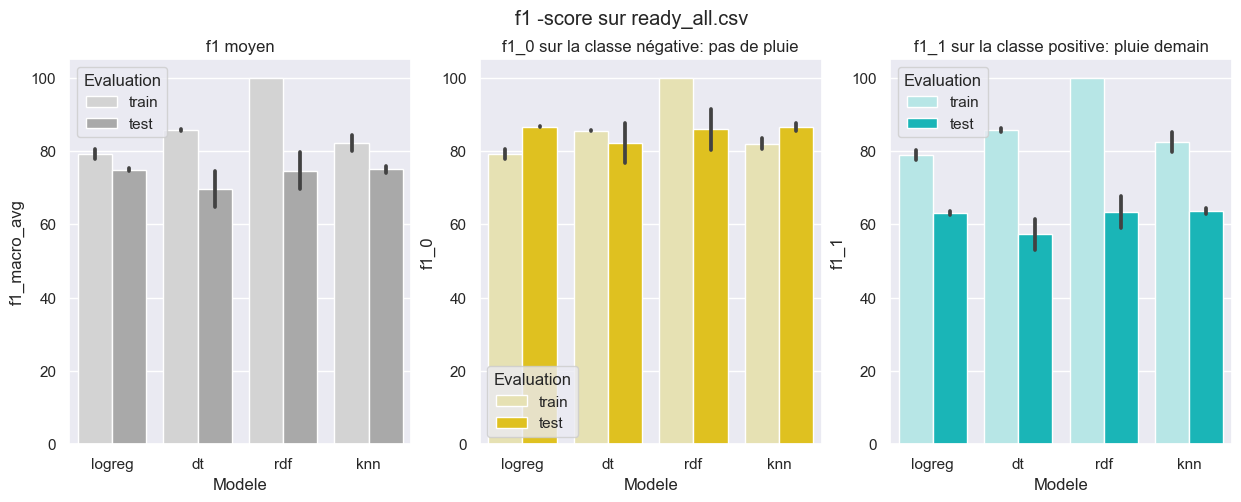

In [13]:
df_report2 = pd.read_csv('alex_df_all/reports/alex_report_all.csv')

fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('f1 -score sur ready_all.csv')

sns.barplot(ax = axes[0], data = df_report2, x = 'Modele', y = 'f1_macro_avg', hue = 'Evaluation', palette= ['lightgrey', 'darkgrey'])
axes[0].set_title("f1 moyen")
           
sns.barplot(ax = axes[1],data = df_report2, x = 'Modele', y = 'f1_0', hue = 'Evaluation', palette=['palegoldenrod', 'gold'])
axes[1].set_title("f1_0 sur la classe négative: pas de pluie")

sns.barplot(ax = axes[2],data = df_report2, x = 'Modele', y = 'f1_1', hue = 'Evaluation', palette=['paleturquoise', 'darkturquoise'])
axes[2].set_title("f1_1 sur la classe positive: pluie demain")

plt.show()

# 3. Essai de rééquilibrage sur logreg via la feature selection:

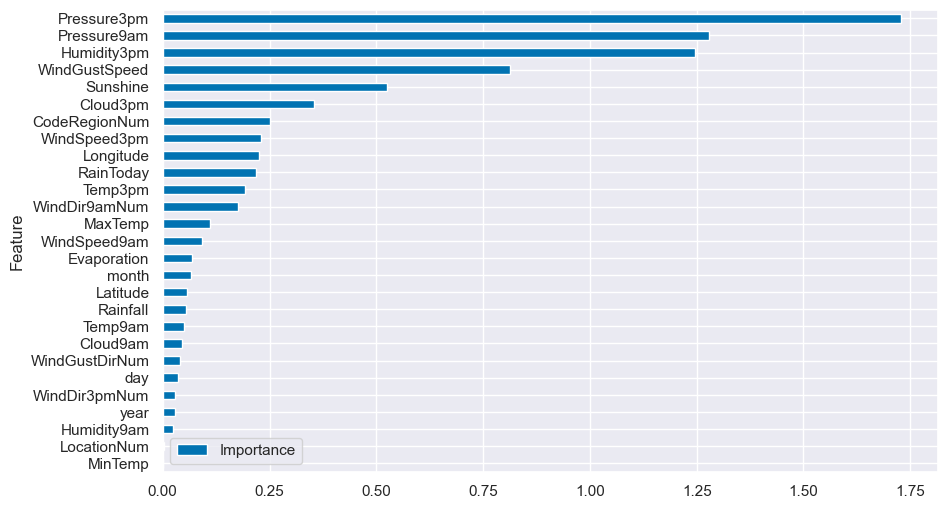

In [14]:
# Features importances pour logreg
# https://forecastegy.com/posts/feature-importance-in-logistic-regression/

logreg_best = load('alex_df_all/model_saves/save_logreg_SMOTE.joblib')

coefficients = logreg_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

In [15]:
feature_importance = feature_importance.sort_values('Importance', ascending=True, ignore_index = True).copy()

In [17]:
# Instanciation df
df = pd.read_csv('ready_all.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])


X = df.drop(columns = ['RainTomorrow', 'Date', 'NonMesNum']).copy()
y = df['RainTomorrow'].copy()

dict_f1 = {}
keyList = ['NFeatsRemoved',  'f1_0', 'f1_1']
dict_f1 = {key: [] for key in keyList}

for i in range(feature_importance.shape[0]-1):
   
    # Séparation data / target:
    X = X.drop(columns = feature_importance['Feature'][i])
  
    # Séparation du jeu d'entrainement et du jeu de test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
    
    # Scale de X_train, X_test:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Oversample avec SMOTE
    smote = SMOTE()
    X_sm, y_sm = smote.fit_resample(X_train, y_train)
    
    # Entrainement du modèle:
    clf = linear_model.LogisticRegression(C = 10)
    clf.fit(X_sm, y_sm)
    
    # Prédiction:
    y_pred = clf.predict(X_test)
    
    # Evaluation:
    f1_0 = f1_score(y_test, y_pred, pos_label = 0)
    f1_1 = f1_score(y_test, y_pred, pos_label = 1)
    #f1_wavg = f1_score(y_test, y_pred, average = 'weighted')
    
    # Enregistrement
    dict_f1['NFeatsRemoved'].append(i+1)
    dict_f1['f1_0'].append(f1_0)
    dict_f1['f1_1'].append(f1_1)
    #dict_f1['f1_weighted_avg'].append(f1_wavg[2])
    
df_f1 = pd.DataFrame.from_dict(dict_f1)
df_f1.to_csv('alex_df_all/reports/dict_f1.csv')

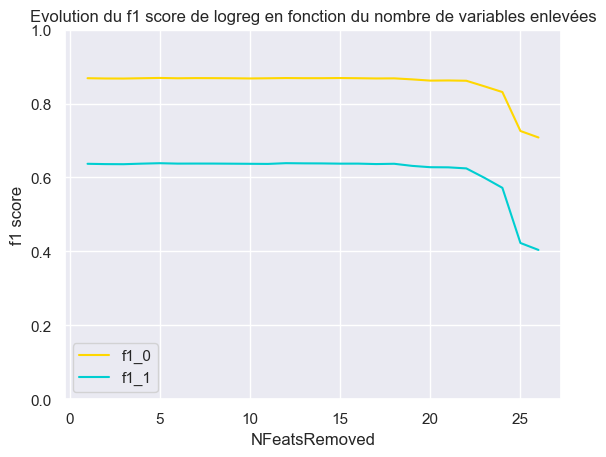

In [18]:
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_0', label = 'f1_0', c = 'gold')
sns.lineplot(data = df_f1, x = 'NFeatsRemoved', y = 'f1_1', label = 'f1_1', c = 'darkturquoise')
plt.ylim([0, 1])
plt.ylabel('f1 score')
plt.title("Evolution du f1 score de logreg en fonction du nombre de variables enlevées")
plt.legend()
plt.show()